# Dive into Deep Learning (DDL): Chapter 14:14.9, 14.4.

Exercise 14.14.9 #1-2

In [2]:
%%capture
!pip install d2l==1.0.3

In [45]:
#Chapter 14.14. Dog Breed Identification (ImageNet Dogs) on Kaggle (https://d2l.ai/chapter_computer-vision/kaggle-dog.html#dog-breed-identification-imagenet-dogs-on-kaggle)

import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [97]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
                            '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

# If you use the full dataset downloaded for the Kaggle competition, change
# the variable below to `False`
demo = False
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'content')

In [98]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv')) #reads the training data labels
    d2l.reorg_train_valid(data_dir, labels, valid_ratio) #splits out the validation set
    d2l.reorg_test(data_dir) #organizes the training set


batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

In [99]:
#image augmentation
transform_train = torchvision.transforms.Compose([
    # Randomly crop the image to obtain an image with an area of 0.08 to 1 of
    # the original area and height-to-width ratio between 3/4 and 4/3. Then,
    # scale the image to create a new 224 x 224 image
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # Randomly change the brightness, contrast, and saturation
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # Add random noise
    torchvision.transforms.ToTensor(),
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [100]:
#prediction, we only use image preprocessing operations without randomness
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # Crop a 224 x 224 square area from the center of the image
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

In [101]:
#read the organized dataset consisting of raw image files
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [102]:
#create data iterator instances
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [103]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True) #model pretrained on the full ImageNet dataset and use it to extract image features to be fed into a custom small-scale output network
    # Define a new output network (there are 120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000, 256), #replace the original output layer with a small custom output network that can be trained, such as stacking two fully connected layers
                                            nn.ReLU(),
                                            nn.Linear(256, 120)) #reuse the input of this model’s output layer (i.e., the extracted features).
    # Move the model to devices
    finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net

In [104]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

In [105]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

KeyboardInterrupt: ignored

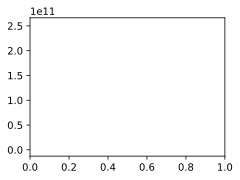

In [106]:
#14.14.9 Question 1: When using the full Kaggle competition dataset, what results can you achieve when you increase batch_size (batch size) and num_epochs (number of epochs) while setting some other hyperparameters as lr = 0.01, lr_period = 10, and lr_decay = 0.1?

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 15, 0.01, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

In [ ]:
#14.14.9 Question 2: Do you get better results if you use a deeper pretrained model? How do you tune hyperparameters? Can you further improve the results?

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)